In [154]:
import warnings
warnings.filterwarnings('ignore')

In [155]:
%matplotlib inline

from datetime import datetime
import pandas as pd
import pandas_datareader.data as web

# replaces pyfinance.ols.PandasRollingOLS (no longer maintained)
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

In [156]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [157]:
DATA_STORE = '../data/assets.h5'


In [158]:
START = 2000
END = 2018

In [196]:
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[str(START):str(END), :], 'adj_close']
              .unstack('ticker'))
    stocks = store['us_equities/stocks'].loc[:, ['marketcap', 'ipoyear', 'sector']]

In [197]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


In [198]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5766 non-null   float64
 1   ipoyear    3038 non-null   float64
 2   sector     5288 non-null   object 
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


In [199]:
stocks = stocks[~stocks.index.duplicated()]
stocks.index.name = 'ticker'

In [200]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6834 entries, PIH to ZYME
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  5766 non-null   float64
 1   ipoyear    3038 non-null   float64
 2   sector     5288 non-null   object 
dtypes: float64(2), object(1)
memory usage: 213.6+ KB


In [201]:
shared = prices.columns.intersection(stocks.index)

In [202]:
stocks = stocks.loc[shared, :]
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2412 entries, A to ZUMZ
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  2407 non-null   float64
 1   ipoyear    1065 non-null   float64
 2   sector     2372 non-null   object 
dtypes: float64(2), object(1)
memory usage: 75.4+ KB


In [203]:
prices = prices.loc[:, shared]
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 86.6 MB


In [204]:
assert prices.shape[1] == stocks.shape[0]


In [205]:
prices.head()

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZEN,ZEUS,ZGNX,ZION,ZIOP,ZIXI,ZNGA,ZOES,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,49.121329,NaN,NaN,NaN,4.975857,NaN,1.025920,NaN,3.596463,NaN,...,NaN,4.466544,NaN,43.826745,NaN,37.06,NaN,NaN,NaN,NaN
2000-01-04,45.369006,NaN,NaN,NaN,4.958913,NaN,1.068476,NaN,3.293170,NaN,...,NaN,4.466544,NaN,41.702530,NaN,36.50,NaN,NaN,NaN,NaN
2000-01-05,41.998737,NaN,NaN,NaN,4.958913,NaN,1.073796,NaN,3.341362,NaN,...,NaN,4.408079,NaN,41.899948,NaN,37.13,NaN,NaN,NaN,NaN
2000-01-06,40.934441,NaN,NaN,NaN,4.958913,NaN,1.082915,NaN,3.052206,NaN,...,NaN,4.350542,NaN,42.247403,NaN,35.25,NaN,NaN,NaN,NaN
2000-01-07,44.345645,NaN,NaN,NaN,4.958913,NaN,1.044918,NaN,3.196784,NaN,...,NaN,4.640083,NaN,42.350060,NaN,38.00,NaN,NaN,NaN,NaN


## Convert business daily datas to monthly to reduce training time

In [206]:
monthly_prices = prices.resample('M').last() # last select the last day of months
monthly_prices

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZEN,ZEUS,ZGNX,ZION,ZIOP,ZIXI,ZNGA,ZOES,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2000-01-31,45.157511,NaN,NaN,NaN,4.766882,NaN,1.211345,NaN,3.333330,NaN,...,NaN,4.176075,NaN,46.927728,NaN,30.88,NaN,NaN,NaN,NaN
2000-02-29,70.884807,NaN,NaN,NaN,4.941969,NaN,1.296459,NaN,3.682567,NaN,...,NaN,4.176075,NaN,42.110354,NaN,53.78,NaN,NaN,NaN,NaN
2000-03-31,70.953031,NaN,NaN,NaN,4.834658,NaN,1.334456,NaN,4.363369,NaN,...,NaN,3.712067,NaN,33.039089,NaN,72.81,NaN,NaN,NaN,NaN
2000-04-30,60.466992,NaN,NaN,NaN,4.360229,NaN,1.595875,NaN,3.985860,NaN,...,NaN,4.408079,NaN,32.935916,NaN,36.94,NaN,NaN,NaN,NaN
2000-05-31,50.233382,NaN,NaN,NaN,4.312221,NaN,1.852735,NaN,2.698793,NaN,...,NaN,4.118538,NaN,36.732135,NaN,28.00,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-30,69.240000,41.51,50.49,72.0000,37.720000,43.66,36.450000,101.00,171.850000,39.36,...,33.61,19.920000,38.85,49.550000,4.570,4.40,4.100,15.98,72.29,21.800
2017-12-31,66.970000,53.87,52.03,81.6000,39.850000,37.82,36.700000,99.69,169.230000,38.24,...,33.84,21.490000,40.05,50.830000,4.140,4.38,4.000,16.72,72.04,20.825
2018-01-31,73.430000,52.02,54.32,69.0241,40.890000,32.39,36.400000,116.99,167.430000,35.26,...,38.52,23.310000,36.30,54.030000,3.945,4.23,3.585,14.72,76.73,20.750


In [207]:
monthly_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 219 entries, 2000-01-31 to 2018-03-31
Freq: M
Columns: 2412 entries, A to ZUMZ
dtypes: float64(2412)
memory usage: 4.0 MB


In [208]:
monthly_prices.tail()

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZEN,ZEUS,ZGNX,ZION,ZIOP,ZIXI,ZNGA,ZOES,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2017-11-30,69.24,41.51,50.49,72.0000,37.72,43.66,36.45,101.00,171.85,39.36,...,33.61,19.92,38.85,49.55,4.570,4.40,4.100,15.98,72.29,21.800
2017-12-31,66.97,53.87,52.03,81.6000,39.85,37.82,36.70,99.69,169.23,38.24,...,33.84,21.49,40.05,50.83,4.140,4.38,4.000,16.72,72.04,20.825
2018-01-31,73.43,52.02,54.32,69.0241,40.89,32.39,36.40,116.99,167.43,35.26,...,38.52,23.31,36.30,54.03,3.945,4.23,3.585,14.72,76.73,20.750
2018-02-28,68.59,44.97,54.25,68.0000,46.21,27.93,36.75,114.25,178.12,31.72,...,43.18,22.53,42.40,54.97,3.730,4.05,3.460,14.88,80.86,19.700
2018-03-31,67.00,44.90,50.90,65.2500,45.42,24.60,38.00,115.01,168.34,32.75,...,47.52,20.25,38.50,52.02,4.050,4.39,3.700,14.88,81.86,23.600


In [209]:
monthly_prices.tail().pct_change(2)

ticker,A,AA,AAL,AAMC,AAN,AAOI,AAON,AAP,AAPL,AAT,...,ZEN,ZEUS,ZGNX,ZION,ZIOP,ZIXI,ZNGA,ZOES,ZTS,ZUMZ
date,,,,,,,,,,,,,,,,,,,,,
2017-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-31,0.060514,0.253192,0.075857,-0.041332,0.084040,-0.258131,-0.001372,0.158317,-0.025720,-0.104167,...,0.146087,0.170181,-0.065637,0.090414,-0.136761,-0.038636,-0.125610,-0.078849,0.061419,-0.048165
2018-02-28,0.024190,-0.165213,0.042668,-0.166667,0.159598,-0.261502,0.001362,0.146053,0.052532,-0.170502,...,0.276005,0.048395,0.058677,0.081448,-0.099034,-0.075342,-0.135000,-0.110048,0.122432,-0.054022
2018-03-31,-0.087566,-0.136870,-0.062960,-0.054678,0.110785,-0.240506,0.043956,-0.016925,0.005435,-0.071185,...,0.233645,-0.131274,0.060606,-0.037202,0.026616,0.037825,0.032078,0.010870,0.066858,0.137349


In [210]:
monthly_prices.tail().pct_change(2).stack().add(1).pow(1/2).sub(1)

date        ticker
2018-01-31  A         0.029813
            AA        0.119461
            AAL       0.037235
            AAMC     -0.020884
            AAN       0.041173
                        ...   
2018-03-31  ZIXI      0.018737
            ZNGA      0.015912
            ZOES      0.005420
            ZTS       0.032888
            ZUMZ      0.066466
Length: 7097, dtype: float64

In [211]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 3, 6, 9, 12]
for lag in lags:
    data[f'return_{lag}m'] = (monthly_prices
                           .pct_change(lag)
                           .stack()
                           .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),       # Clip the return to threshold
                                                  upper=x.quantile(1-outlier_cutoff)))    # pipe acts like map for df
                           .add(1)
                           .pow(1/lag)
                           .sub(1)
                           )
data.loc[('2018-01-31', 'A')]
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2000-02-29 A        0.430943        NaN        NaN        NaN        NaN   
           AAN      0.036730        NaN        NaN        NaN        NaN   
           AAON     0.070263        NaN        NaN        NaN        NaN   
           AAPL     0.104771        NaN        NaN        NaN        NaN   
           ABAX    -0.007631        NaN        NaN        NaN        NaN   
...                      ...        ...        ...        ...        ...   
2018-03-31 ZIXI     0.083951   0.018737   0.000760  -0.017817  -0.028409   
           ZNGA     0.069364   0.015912  -0.025652  -0.003559   0.001818   
           ZOES     0.000000   0.005420  -0.038117   0.027701   0.025046   
           ZTS      0.012367   0.032888   0.043517   0.042527   0.030657   
           ZUMZ     0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m  
date       ticker              
2000-02-29 A              NaN  
           AAN            NaN  
           AAON           NaN  
           AAPL           NaN  
           ABAX           NaN  
...                       ...  
2018-03-31 ZIXI     -0.007585  
           ZNGA      0.021989  
           ZOES     -0.017982  
           ZTS       0.036608  
           ZUMZ      0.021422  

[425983 rows x 6 columns]

In [212]:
data = data.swaplevel().dropna() # Change order of index (from (date, ticker) -> (ticker, date))
                                # default dropna drops rows with missing values
data

,,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
ticker,date,,,,,,
A,2001-01-31,-0.003653,0.022360,0.056104,0.049811,-0.052500,-0.015988
AAN,2001-01-31,0.116071,0.008439,-0.015687,-0.009856,-0.002912,-0.009572
AAON,2001-01-31,0.300170,0.034296,0.028670,-0.006238,0.010159,0.031027
AAPL,2001-01-31,0.430943,0.144685,0.033941,-0.132736,-0.110514,-0.070339
ABAX,2001-01-31,-0.073762,-0.042573,-0.044914,-0.003738,-0.028353,-0.031993
...,...,...,...,...,...,...,...
ZIXI,2018-03-31,0.083951,0.018737,0.000760,-0.017817,-0.028409,-0.007585
ZNGA,2018-03-31,0.069364,0.015912,-0.025652,-0.003559,0.001818,0.021989
ZOES,2018-03-31,0.000000,0.005420,-0.038117,0.027701,0.025046,-0.017982


In [213]:
# Drop stock with less than 10yrs return
min_obs = 120
nobs = data.groupby(level='ticker').size()
keep = nobs[nobs>min_obs].index

data = data.loc[idx[keep,:], :]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
dtypes: float64(6)
memory usage: 18.0+ MB


In [214]:
data.describe()

,return_1m,return_2m,return_3m,return_6m,return_9m,return_12m
count,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000,360752.000000
mean,0.012255,0.009213,0.008181,0.007025,0.006552,0.006296
std,0.114236,0.081170,0.066584,0.048474,0.039897,0.034792
min,-0.329564,-0.255452,-0.214783,-0.162063,-0.131996,-0.114283
25%,-0.046464,-0.030716,-0.023961,-0.014922,-0.011182,-0.009064
50%,0.009448,0.009748,0.009744,0.009378,0.008982,0.008726
75%,0.066000,0.049249,0.042069,0.031971,0.027183,0.024615
max,0.430943,0.281819,0.221789,0.154555,0.124718,0.106371


In [215]:
data.index.get_level_values('ticker').nunique()


1838

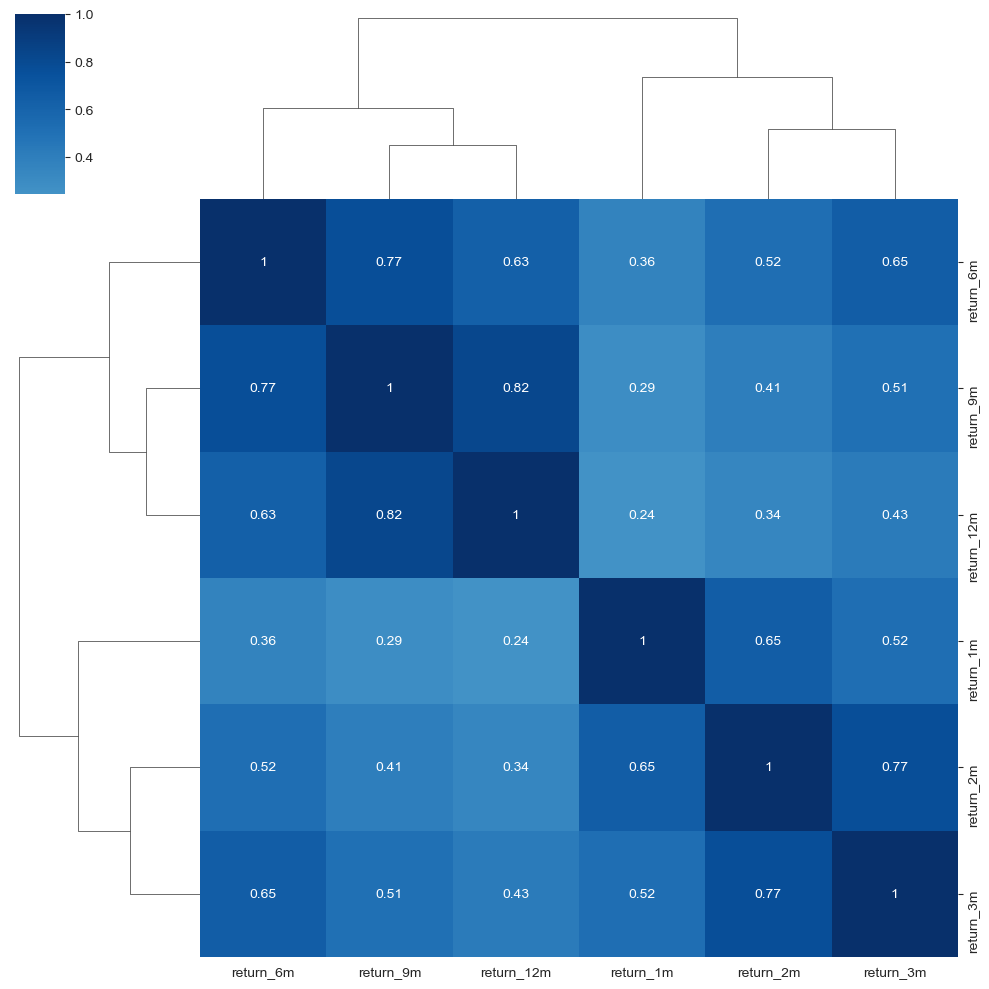

In [216]:
# Spearman correlation measures the monotonic relation (not necessary linear relation) between 2 variables
# (just increase or decrease together, not necessary linear)
# Normal correlation measures linear relation between 2 variables
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues')


# Market Risk Premium (Mkt-RF):
This factor represents the excess return of the market portfolio (e.g., S&P 500) over the risk-free rate. It measures the return earned by investors for bearing systematic risk associated with the overall market.
A positive Mkt-RF indicates that the market outperformed the risk-free rate, while a negative value indicates underperformance.

# Small Minus Big (SMB):
SMB measures the historic excess returns of small-cap stocks relative to large-cap stocks. Small-cap stocks tend to outperform large-cap stocks over the long term, as they are riskier and less liquid.
A positive SMB suggests that small-cap stocks outperformed large-cap stocks, while a negative value indicates underperformance.

# High Minus Low (HML):
HML measures the historic excess returns of value stocks relative to growth stocks. Value stocks are those with low prices relative to fundamental metrics such as book value, while growth stocks have high prices relative to these metrics.
A positive HML indicates that value stocks outperformed growth stocks, while a negative value indicates underperformance.

# Robust Minus Weak (RMW):
RMW captures the historic excess returns of companies with high operating profitability relative to those with low operating profitability. Companies with high profitability tend to outperform those with low profitability.
A positive RMW suggests that high-profitability companies outperformed low-profitability companies, while a negative value indicates underperformance.

# Conservative Minus Aggressive (CMA):
CMA measures the historic excess returns of companies that invest conservatively (e.g., low levels of investment) relative to those that invest aggressively (e.g., high levels of investment). Conservative firms tend to outperform aggressive firms.
A positive CMA indicates that conservative firms outperformed aggressive firms, while a negative value indicates underperformance.

In [217]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', data_source='famafrench', start='2000')[0].drop(columns=['RF'])
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last() / 100
factor_data.index.name = 'date'
factor_data


,Mkt-RF,SMB,HML,RMW,CMA
date,,,,,
2000-01-31,-0.0474,0.0442,-0.0188,-0.0629,0.0472
2000-02-29,0.0245,0.1828,-0.0959,-0.1865,-0.0048
2000-03-31,0.0520,-0.1532,0.0813,0.1179,-0.0159
2000-04-30,-0.0640,-0.0501,0.0726,0.0766,0.0565
2000-05-31,-0.0442,-0.0381,0.0475,0.0413,0.0137
...,...,...,...,...,...
2023-08-31,-0.0239,-0.0365,-0.0106,0.0343,-0.0237
2023-09-30,-0.0524,-0.0180,0.0152,0.0186,-0.0083
2023-10-31,-0.0319,-0.0404,0.0019,0.0246,-0.0066


In [218]:
data['return_1m']

ticker  date      
A       2001-01-31   -0.003653
        2001-02-28   -0.329564
        2001-03-31   -0.146389
        2001-04-30    0.269444
        2001-05-31   -0.140220
                        ...   
ZUMZ    2017-11-30    0.235127
        2017-12-31   -0.044725
        2018-01-31   -0.003601
        2018-02-28   -0.050602
        2018-03-31    0.197970
Name: return_1m, Length: 360752, dtype: float64

In [219]:
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data.loc[('A', '2001-05-31')]

Mkt-RF       0.00720
SMB          0.03600
HML          0.03360
RMW          0.00250
CMA          0.01910
return_1m   -0.14022
Name: (A, 2001-05-31 00:00:00), dtype: float64

In [220]:
factor_data.loc[(('AAPL', '2001-05-31'))]

Mkt-RF       0.00720
SMB          0.03600
HML          0.03360
RMW          0.00250
CMA          0.01910
return_1m   -0.21734
Name: (AAPL, 2001-05-31 00:00:00), dtype: float64

In [221]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
ticker date                                                         
A      2001-01-31  0.0313  0.0548 -0.0507 -0.0469 -0.0503  -0.003653
       2001-02-28 -0.1005  0.0283  0.1247  0.0910  0.0907  -0.329564
       2001-03-31 -0.0726  0.0233  0.0642  0.0335  0.0392  -0.146389
       2001-04-30  0.0794 -0.0086 -0.0467 -0.0306 -0.0320   0.269444
       2001-05-31  0.0072  0.0360  0.0336  0.0025  0.0191  -0.140220
...                   ...     ...     ...     ...     ...        ...
ZUMZ   2017-11-30  0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.235127
       2017-12-31  0.0106 -0.0107  0.0006  0.0074  0.0169  -0.044725
       2018-01-31  0.0557 -0.0318 -0.0129 -0.0076 -0.0096  -0.003601
       2018-02-28 -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.050602
       2018-03-31 -0.0235  0.0359 -0.0021 -0.0046  0.0001   0.197970

[360752 rows x 6 columns]

In [222]:
temp = factor_data.groupby(level='ticker')

temp.get_group('A')

Mkt-RF     SMB     HML     RMW     CMA  return_1m
ticker date                                                         
A      2001-01-31  0.0313  0.0548 -0.0507 -0.0469 -0.0503  -0.003653
       2001-02-28 -0.1005  0.0283  0.1247  0.0910  0.0907  -0.329564
       2001-03-31 -0.0726  0.0233  0.0642  0.0335  0.0392  -0.146389
       2001-04-30  0.0794 -0.0086 -0.0467 -0.0306 -0.0320   0.269444
       2001-05-31  0.0072  0.0360  0.0336  0.0025  0.0191  -0.140220
...                   ...     ...     ...     ...     ...        ...
       2017-11-30  0.0312 -0.0033 -0.0003  0.0316 -0.0005   0.017786
       2017-12-31  0.0106 -0.0107  0.0006  0.0074  0.0169  -0.032785
       2018-01-31  0.0557 -0.0318 -0.0129 -0.0076 -0.0096   0.096461
       2018-02-28 -0.0365  0.0032 -0.0104  0.0052 -0.0237  -0.065913
       2018-03-31 -0.0235  0.0359 -0.0021 -0.0046  0.0001  -0.023181

[207 rows x 6 columns]

## We seek to find a linear relation among these factors and 1m_return of stocks
## RollingOLS
y = Beta * X (All in vector form), then y is endogenous variable (endog), while X is exogenous variable (exog).
RollingOLS applies linear regression through window_size (= n) iterations. (Fitting first nth points, then drop the oldest points and move to the 2nd n_size window to continue fitting).
## sm.add_constant()
Add a constant column (x0) to exogenous matrix X to perform linear regression



In [223]:
T = 24
betas = (factor_data.groupby(level='ticker',
                             group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(T, x.shape[0]-1))
                .fit(params_only=True)
                .params
                .drop(columns=['const'])
               ))

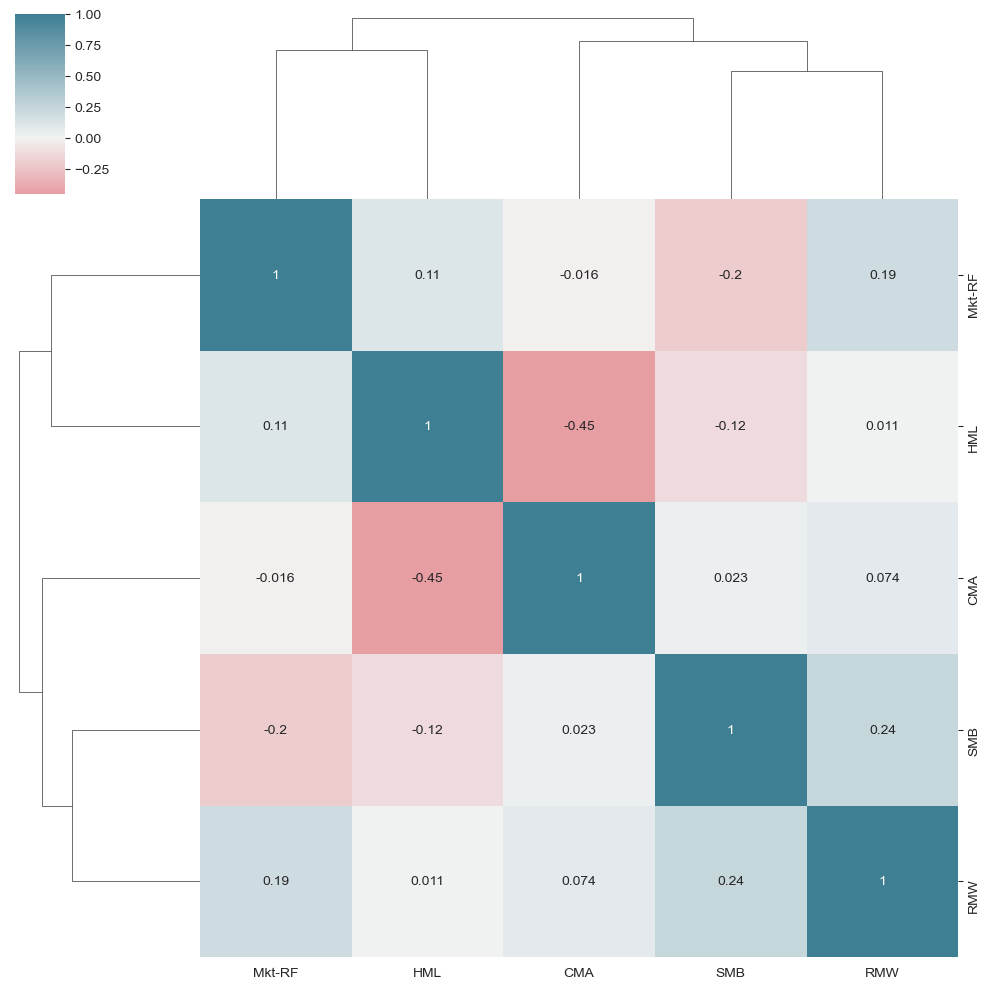

In [224]:
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.clustermap(betas.corr(), annot=True, cmap=cmap, center=0);

In [225]:
betas.loc['AAPL'].head(30)
betas.head()

Mkt-RF  SMB  HML  RMW  CMA
ticker date                                  
A      2001-01-31     NaN  NaN  NaN  NaN  NaN
       2001-02-28     NaN  NaN  NaN  NaN  NaN
       2001-03-31     NaN  NaN  NaN  NaN  NaN
       2001-04-30     NaN  NaN  NaN  NaN  NaN
       2001-05-31     NaN  NaN  NaN  NaN  NaN

In [226]:
data = (data
        .join(betas
              .groupby(level='ticker')
              .shift()))



In [227]:
data.head()

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   

                   return_12m  Mkt-RF  SMB  HML  RMW  CMA  
ticker date                                                
A      2001-01-31   -0.015988     NaN  NaN  NaN  NaN  NaN  
       2001-02-28   -0.084537     NaN  NaN  NaN  NaN  NaN  
       2001-03-31   -0.096606     NaN  NaN  NaN  NaN  NaN  
       2001-04-30   -0.066102     NaN  NaN  NaN  NaN  NaN  
       2001-05-31   -0.063425     NaN  NaN  NaN  NaN  NaN

## Impute missing data with mean

In [228]:
data.loc[:, factors] = data.groupby('ticker')[factors].apply(lambda x: x.fillna(x.mean()))
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   return_1m   360752 non-null  float64
 1   return_2m   360752 non-null  float64
 2   return_3m   360752 non-null  float64
 3   return_6m   360752 non-null  float64
 4   return_9m   360752 non-null  float64
 5   return_12m  360752 non-null  float64
 6   Mkt-RF      360752 non-null  float64
 7   SMB         360752 non-null  float64
 8   HML         360752 non-null  float64
 9   RMW         360752 non-null  float64
 10  CMA         360752 non-null  float64
dtypes: float64(11)
memory usage: 39.8+ MB


## Momentum Factors based on the difference between returns over longer periods and the most recent monthly returns

In [229]:
for lag in [2,3,6,9,12]:
    data[f'momentum_{lag}'] = data[f'return_{lag}m'].sub(data.return_1m)
data[f'momentum_3_12'] = data[f'return_12m'].sub(data.return_3m)
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
ticker date                                                             
A      2001-01-31   -0.015988  1.264316  0.573533 -0.673074 -1.252138   
       2001-02-28   -0.084537  1.264316  0.573533 -0.673074 -1.252138   
       2001-03-31   -0.096606  1.264316  0.573533 -0.673074 -1.252138   
       2001-04-30   -0.066102  1.264316  0.573533 -0.673074 -1.252138   
       2001-05-31   -0.063425  1.264316  0.573533 -0.673074 -1.252138   
...                       ...       ...       ...       ...       ...   
ZUMZ   2017-11-30   -0.010687 -0.780979  1.007022  1.363240  2.978556   
       2017-12-31   -0.003996 -0.775796  1.327020  1.336272  3.474425   
       2018-01-31    0.002864 -0.970033  1.658541  1.531017  3.655010   
       2018-02-28   -0.002905  0.065406  1.156550  1.321246  2.979204   
       2018-03-31    0.021422  0.326675  1.020393  1.345950  2.712224   

                        CMA  momentum_2  momentum_3  momentum_6  momentum_9  \
ticker date                                                                   
A      2001-01-31  0.699290    0.026013    0.059757    0.053464   -0.048847   
       2001-02-28  0.699290    0.140448    0.213128    0.245423    0.253138   
       2001-03-31  0.699290   -0.103054   -0.028727    0.071761    0.053699   
       2001-04-30  0.699290   -0.228477   -0.375191   -0.297629   -0.274280   
       2001-05-31  0.699290    0.184941    0.116903    0.069178    0.075921   
...                     ...         ...         ...         ...         ...   
ZUMZ   2017-11-30  1.257435   -0.137667   -0.029826   -0.161698   -0.227725   
       2017-12-31  0.982165    0.130951    0.092582    0.135712    0.059190   
       2018-01-31  0.334506   -0.020778    0.059019    0.088866    0.019838   
       2018-02-28  0.647188    0.023217    0.017402    0.130086    0.087242   
       2018-03-31  0.680867   -0.131504   -0.155390   -0.152755   -0.123363   

                   momentum_12  momentum_3_12  
ticker date                                    
A      2001-01-31    -0.012335      -0.072092  
       2001-02-28     0.245026       0.031898  
       2001-03-31     0.049783       0.078511  
       2001-04-30    -0.335545       0.039645  
       2001-05-31     0.076795      -0.040108  
...                        ...            ...  
ZUMZ   2017-11-30    -0.245814      -0.215989  
       2017-12-31     0.040729      -0.051853  
       2018-01-31     0.006465      -0.052554  
       2018-02-28     0.047697       0.030295  
       2018-03-31    -0.176548      -0.021157  

[360752 rows x 17 columns]

In [230]:
dates = data.index.get_level_values('date')
data['year'] = dates.year
data['month'] = dates.month
data

return_1m  return_2m  return_3m  return_6m  return_9m  \
ticker date                                                                
A      2001-01-31  -0.003653   0.022360   0.056104   0.049811  -0.052500   
       2001-02-28  -0.329564  -0.189115  -0.116435  -0.084141  -0.076425   
       2001-03-31  -0.146389  -0.249443  -0.175116  -0.074628  -0.092690   
       2001-04-30   0.269444   0.040966  -0.105747  -0.028185  -0.004837   
       2001-05-31  -0.140220   0.044721  -0.023317  -0.071042  -0.064299   
...                      ...        ...        ...        ...        ...   
ZUMZ   2017-11-30   0.235127   0.097461   0.205302   0.073430   0.007402   
       2017-12-31  -0.044725   0.086226   0.047857   0.090987   0.014465   
       2018-01-31  -0.003601  -0.024380   0.055418   0.085265   0.016237   
       2018-02-28  -0.050602  -0.027386  -0.033200   0.079484   0.036640   
       2018-03-31   0.197970   0.066466   0.042579   0.045215   0.074606   

                   return_12m    Mkt-RF       SMB       HML       RMW  \
ticker date                                                             
A      2001-01-31   -0.015988  1.264316  0.573533 -0.673074 -1.252138   
       2001-02-28   -0.084537  1.264316  0.573533 -0.673074 -1.252138   
       2001-03-31   -0.096606  1.264316  0.573533 -0.673074 -1.252138   
       2001-04-30   -0.066102  1.264316  0.573533 -0.673074 -1.252138   
       2001-05-31   -0.063425  1.264316  0.573533 -0.673074 -1.252138   
...                       ...       ...       ...       ...       ...   
ZUMZ   2017-11-30   -0.010687 -0.780979  1.007022  1.363240  2.978556   
       2017-12-31   -0.003996 -0.775796  1.327020  1.336272  3.474425   
       2018-01-31    0.002864 -0.970033  1.658541  1.531017  3.655010   
       2018-02-28   -0.002905  0.065406  1.156550  1.321246  2.979204   
       2018-03-31    0.021422  0.326675  1.020393  1.345950  2.712224   

                        CMA  momentum_2  momentum_3  momentum_6  momentum_9  \
ticker date                                                                   
A      2001-01-31  0.699290    0.026013    0.059757    0.053464   -0.048847   
       2001-02-28  0.699290    0.140448    0.213128    0.245423    0.253138   
       2001-03-31  0.699290   -0.103054   -0.028727    0.071761    0.053699   
       2001-04-30  0.699290   -0.228477   -0.375191   -0.297629   -0.274280   
       2001-05-31  0.699290    0.184941    0.116903    0.069178    0.075921   
...                     ...         ...         ...         ...         ...   
ZUMZ   2017-11-30  1.257435   -0.137667   -0.029826   -0.161698   -0.227725   
       2017-12-31  0.982165    0.130951    0.092582    0.135712    0.059190   
       2018-01-31  0.334506   -0.020778    0.059019    0.088866    0.019838   
       2018-02-28  0.647188    0.023217    0.017402    0.130086    0.087242   
       2018-03-31  0.680867   -0.131504   -0.155390   -0.152755   -0.123363   

                   momentum_12  momentum_3_12  year  month  
ticker date                                                 
A      2001-01-31    -0.012335      -0.072092  2001      1  
       2001-02-28     0.245026       0.031898  2001      2  
       2001-03-31     0.049783       0.078511  2001      3  
       2001-04-30    -0.335545       0.039645  2001      4  
       2001-05-31     0.076795      -0.040108  2001      5  
...                        ...            ...   ...    ...  
ZUMZ   2017-11-30    -0.245814      -0.215989  2017     11  
       2017-12-31     0.040729      -0.051853  2017     12  
       2018-01-31     0.006465      -0.052554  2018      1  
       2018-02-28     0.047697       0.030295  2018      2  
       2018-03-31    -0.176548      -0.021157  2018      3  

[360752 rows x 19 columns]

## Lagged return 

In [231]:
for t in range(1, 7):
    data[f'return_1m_t-{t}'] = data.groupby(level='ticker').return_1m.shift(t)
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 360752 entries, ('A', Timestamp('2001-01-31 00:00:00', freq='M')) to ('ZUMZ', Timestamp('2018-03-31 00:00:00', freq='M'))
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   return_1m      360752 non-null  float64
 1   return_2m      360752 non-null  float64
 2   return_3m      360752 non-null  float64
 3   return_6m      360752 non-null  float64
 4   return_9m      360752 non-null  float64
 5   return_12m     360752 non-null  float64
 6   Mkt-RF         360752 non-null  float64
 7   SMB            360752 non-null  float64
 8   HML            360752 non-null  float64
 9   RMW            360752 non-null  float64
 10  CMA            360752 non-null  float64
 11  momentum_2     360752 non-null  float64
 12  momentum_3     360752 non-null  float64
 13  momentum_6     360752 non-null  float64
 14  momentum_9     360752 non-null  float64
 15  momentum_12    360752 non